# Connect Intensive - Machine Learning Nanodegree
# Lesson 09: Reinforcement Learning - Gridworld!

## Objectives
  - Solve the state value function $v(s)$ for the gridworld problem iteratively.
  - Use the greedy policy to improve the random policy for gridworld actions.
  - Visualize the state value function and greedy policy after each iteration.
  
## Prerequisites
  - You should have the following python packages installed:
    - [matplotlib](http://matplotlib.org/index.html)
    - [numpy](http://www.scipy.org/scipylib/download.html)

    
## Acknowledgements
The code from this notebook is loosely inspired by [Shangtong Zhang's python code](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction), particularly [the GridWorld.py code](https://github.com/ShangtongZhang/reinforcement-learning-an-introduction/blob/master/chapter03/GridWorld.py) that accompanies Chapter 3 of Sutton and Barto's textbook [Reinforcement Learning: an Introduction](https://webdocs.cs.ualberta.ca/~sutton/book/the-book.html). Shangtong Zhang's copyright notice is in the cell below.

In [1]:
#######################################################################
# Copyright (C) 2016 Shangtong Zhang(zhangshangtong.cpp@gmail.com)    #
# Permission given to modify the code as long as you keep this        #
# declaration at the top                                              #
#######################################################################

## Agents in Gridworld

This week's lesson notebook is pretty brief, but it should illustrate how the [Bellman equation](https://en.wikipedia.org/wiki/Bellman_equation) can be solved iteratively for a prescribed policy. The prescribed policy for our reinforcement learning agent is random movement: the agent is navigating a 2-d world and at every timestep can move north, south, east, or west in an effort to reach a terminal state (or a goal) in the gridworld. To hurry the agent along, there is a negative reward of -1 at each timestep until the agent is in the goal.

To evaluate how well the random policy works in the gridworld, we can iteratively solve the Bellman equation until the state value function converges for each state. The `Grid` class below has methods to do so, and to visualize our progress along the way:
  - `iterate_value_function()`: Performs one step of the iteration toward solving the Bellman equation.
  - `iterate_to_convergence()`: Iterates until the state value function converges to within a specified tolerance.
  - `show_greedy_policy()`: Shows the state value function for gridworld and the corresponding greedy policy at the current iteration.
  
Read through, then **run** the cell below so that we can use the `Grid` class.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Grid:
    
    def __init__(self, nrows=5, ncols=5, goals = [(4,4)], discount = 1.0):
    # @nrows: (integer) The number of rows in the gridworld
    # @ncols: (integer) The number of columns in the gridworld
    # @goals: (list of tuples) The cell or cells that are terminal state(s in gridworld
    # @discount: (float) The discount factor, gamma, for computing state value function
    
        # Set the dimensions of gridworld
        self.nrows = nrows
        self.ncols = ncols
        
        # Counter for number of iterations in solution of Bellman equation
        # for the state value function v(s)
        self.k = 0
        
        # Initialize the state value function to be zero for all states
        self.values = np.zeros((nrows,ncols))
        
        # RL agent is finding a goal or terminal state as fast as possible,
        # so reward is -1 for all actions to incentivize fast routes to the goal
        self.rewards = - np.ones((nrows,ncols))
        
        # Terminal states for the gridworld
        self.goals = goals
        
        # The discount factor, gamma
        self.discount = discount
        
        # Policy is random -- RL agent randomly selects one of four actions
        self.prob = {'N':0.25,'S':0.25,'E':0.25,'W':0.25}
        
        # Summed difference between new and old state value functions
        # for one interation of Bellman equation (check for convergence)
        self.diff = np.inf
        
        # Tolerance for convergence of the iterative solution of Bellman equation
        self.tolerance = 1e-4
            
    def iterate_value_function(self):
        # Perform one iteration of iterative Bellman equation to determine
        # the state value function for the random policy in the gridworld
        
        # Increment the number of iterations
        self.k += 1
        
        # Initialize a matrix for the new state value function after one iteration
        new_values = np.zeros((self.nrows,self.ncols))
        
        # We are going to iterate over each cell within the gridworld
        for row in np.arange(self.nrows):
            for col in np.arange(self.ncols):
                # Only update non-terminal states
                if (row,col) not in self.goals:
                    # When solving the Bellman equations, you add two things:
                    #  1. the immediate reward upon taking the action, and
                    #  2. the discounted value of the state to which you moved
                    
                    # Action: Move North
                    if row == 0:
                        # Cannot move North in the top row of gridworld
                        north = self.rewards[( row , col )] + self.discount * self.values[( row , col )]
                    else:
                        north = self.rewards[(row-1, col )] + self.discount * self.values[(row-1, col )]
                        
                    # Action: Move South
                    if row == self.nrows-1:
                        # Cannot move South in the bottom row of gridworld
                        south = self.rewards[( row , col )] + self.discount * self.values[( row , col )]
                    else:
                        south = self.rewards[(row+1, col )] + self.discount * self.values[(row+1, col )]
                        
                    # Action: Move West
                    if col == 0:
                        # Cannot move West in the leftmost column of gridworld
                        west = self.rewards[( row , col )] + self.discount * self.values[( row , col )]
                    else:
                        west = self.rewards[( row ,col-1)] + self.discount * self.values[( row ,col-1)]
                        
                    # Action: Move East
                    if col == self.ncols-1:
                        # Cannot move East in the rightmost column of gridworld
                        east = self.rewards[( row , col )] + self.discount * self.values[( row , col )]
                    else:
                        east = self.rewards[( row ,col+1)] + self.discount * self.values[( row ,col+1)]
                        
                    # Add up all contributions to the new state value function
                    new_values[(row,col)] = self.prob['N'] * north + \
                                            self.prob['S'] * south + \
                                            self.prob['E'] * east  + \
                                            self.prob['W'] * west
                else:
                    # Value of terminal state is unchanged
                    new_values[(row,col)] = self.values[(row,col)]
                    
        # Find difference between old and new state value function
        self.diff = np.sum(np.abs(self.values-new_values))
        
        # Save new values
        self.values = new_values
        
    def iterate_to_convergence(self):
        # Iteratively solve the Bellman equation until convergence
        while self.diff > self.tolerance:
            self.iterate_value_function()
        print("Converged to tolerance of {}!".format(self.tolerance))
            
    def show_greedy_policy(self):
        # Create two subplots
        # Subplot 1: Current state value function v_k(s), after k iterations
        # Subplot 2: Improvement: greedy policy using v_k(s), after k iterations
        fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
        
        # Set x and y limits of both subplots based on gridworld dimensions
        ax1.set_xlim([0,self.ncols])
        ax1.set_ylim([-self.nrows,0])
        ax2.set_xlim([0,self.ncols])
        ax2.set_ylim([-self.nrows,0])
        
        # Iterate through each cell of the gridworld
        for row in np.arange(self.nrows):
            for col in np.arange(self.ncols):
                # Terminal states or goal cells will be gold
                # Non-terminal states will be empty
                if (row,col) in self.goals:
                    color_fill = "gold"
                else:
                    color_fill = "none"
                # Add a rectangle patch for the current cell of gridworld
                ax1.add_patch(
                    patches.Rectangle(
                    (col, -(row+1)),
                    1.0,
                    1.0,
                    facecolor=color_fill,
                    linewidth=3
                    )
                )
                ax2.add_patch(
                    patches.Rectangle(
                    (col, -(row+1)),
                    1.0,
                    1.0,
                    facecolor=color_fill,
                    linewidth=3
                    )
                )
                # For subplot 1, add text for the state value function
                # at the current iteration of the Bellman equation
                ax1.text(col+0.5, -(row+1)+0.5,'{:.2f}'.format(self.values[(row,col)]),
                        horizontalalignment='center',
                        verticalalignment='center',
                        fontsize=12)
                # For subplot 2, draw arrows representing the 
                # improved (greedy) policy for all non-terminal states
                if (row,col) not in self.goals:
                    # max_dir will contain a list of the greedy policy actions
                    # for the current state (row, col)
                    max_dir = []
                    # Initialize the maximum value to -infinity
                    max_val = -np.inf
                    # check state value function for "north" action
                    if not row == 0:
                        if np.abs(max_val - self.values[(row-1,col)]) < self.tolerance:
                            max_dir.append('N')
                        elif self.values[(row-1,col)] > max_val:
                            max_val = self.values[(row-1,col)]
                            max_dir = ['N']
                    elif np.abs(max_val - self.values[(row,col)]) < self.tolerance:
                        max_dir.append('N')
                    elif self.values[(row,col)] > max_val:
                        max_val = self.values[(row,col)]
                        max_dir = ['N']

                        
                    # check state value function for "south" action
                    if not row == self.nrows-1:
                        if np.abs(max_val - self.values[(row+1,col)]) < self.tolerance:
                            max_dir.append('S')
                        elif self.values[(row+1,col)] > max_val:
                            max_val = self.values[(row+1,col)]
                            max_dir = ['S']
                    elif np.abs(max_val - self.values[(row,col)]) < self.tolerance:
                        max_dir.append('S')
                    elif self.values[(row,col)] > max_val:
                        max_val = self.values[(row,col)]
                        max_dir = ['S']

                        
                    # check state value function for "west" action
                    if not col == 0:
                        if np.abs(max_val - self.values[(row,col-1)]) < self.tolerance:
                            max_dir.append('W')
                        elif self.values[(row,col-1)] > max_val:
                            max_val = self.values[(row,col-1)]
                            max_dir = ['W']
                    elif np.abs(max_val - self.values[(row,col)]) < self.tolerance:
                        max_dir.append('W')
                    elif self.values[(row,col)] > max_val:
                        max_val = self.values[(row,col)]
                        max_dir = ['W']

                        
                    # check state value function for "east" action
                    if not col == self.ncols-1:
                        if np.abs(max_val - self.values[(row,col+1)]) < self.tolerance:
                            max_dir.append('E')
                        elif self.values[(row,col+1)] > max_val:
                            max_val = self.values[(row,col+1)]
                            max_dir = ['E']
                    elif np.abs(max_val - self.values[(row,col)]) < self.tolerance:
                        max_dir.append('E')
                    elif self.values[(row,col)] > max_val:
                        max_val = self.values[(row,col)]
                        max_dir = ['E']

                        
                    # Arrows are centered in each gridworld cell
                    x = col+0.5
                    y = -(row+1)+0.5
                    
                    # For each direction in the greedy policy, draw the arrow
                    for direc in max_dir:
                        if direc == 'N':
                            dx = 0
                            dy = 0.25
                        elif direc == 'S':
                            dx = 0
                            dy = -0.25
                        if direc == 'E':
                            dx = 0.25
                            dy = 0
                        elif direc == 'W':
                            dx = -0.25
                            dy = 0
                        ax2.arrow(x,y,dx,dy,head_width=0.1, fc='k', ec='k')
        
        # Remove tick marks on both subplots, and title/label the subplots
        ax1.axes.get_xaxis().set_ticks([])
        ax1.axes.get_yaxis().set_ticks([])
        ax1.set_title('State Value Function $v_k(s)$\nRandom Policy, $k={}$ Iteration(s)'.format(self.k))
        ax1.set_xlabel('Discount Factor $\gamma={:.1f}$'.format(self.discount),fontsize=12)
        ax2.set_axis_off()
        ax2.set_title('Greedy Policy\nwith respect to $v_k(s)$')


/Library/Python/2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Now let's create a gridworld! Let's make it $4\times4$ with a single terminal state in the southeast corner, cell (3,3). Let's be far-sighted and set the discount factor $\gamma$ for the [Markov Decision Process](https://en.wikipedia.org/wiki/Markov_decision_process) to 1.0. This way, we're not discounting long-term rewards. **Run** the cell below to do so. You will see that the state value function $v_k(s)$ has been initialized to zero for all states, and if we were to create a greedy policy from this initial value, no action is preferred over any other just yet. *Note:* actions that would move the agent outside the gridworld (for example, the *North* action on the topmost edge of gridworld) leave the agent where it is for the current timestep.

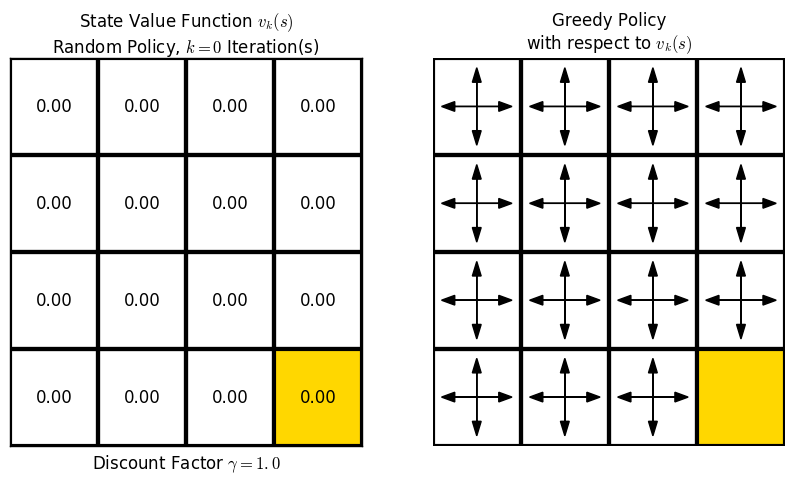

In [3]:
g1 = Grid(nrows=4, ncols=4, goals = [(3,3)], discount = 1.0)
g1.show_greedy_policy()

Now **run** the cell below to perform one iteration in the solution of the Bellman equation to find $v_1(s)$. You should find that all but the goal state get a negative reward of -1. Does that influence the resulting greedy policy?

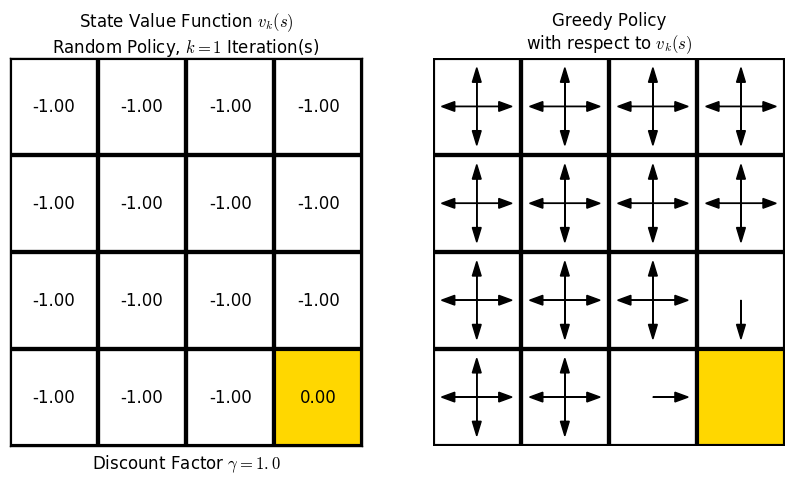

In [4]:
g1.iterate_value_function()
g1.show_greedy_policy()

Now **run** the cell below to perform a second iteration in the solution of the Bellman equation to find $v_1(s)$. Things start to get interesting. The information from the goal state starts to propagate further into the gridworld, and the cells farther from the gridworld goal continue to get penalized the hardest.

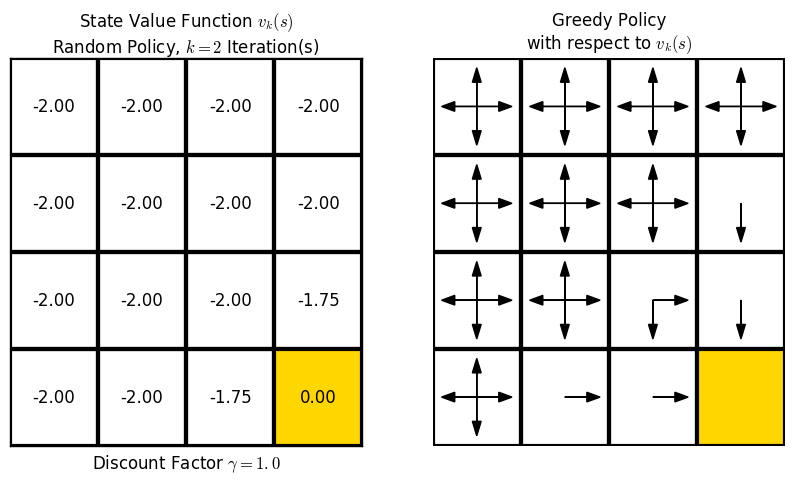

In [5]:
g1.iterate_value_function()
g1.show_greedy_policy()

**Run** the cell below for a third, fourth, fifth, and sixth iteration...

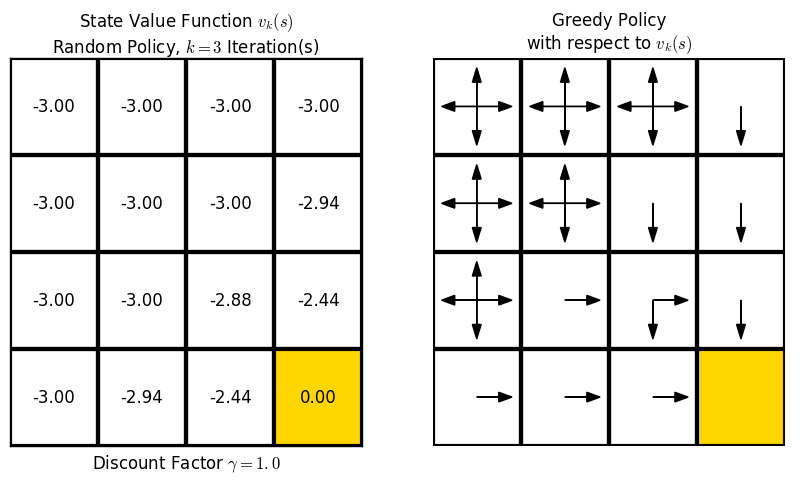

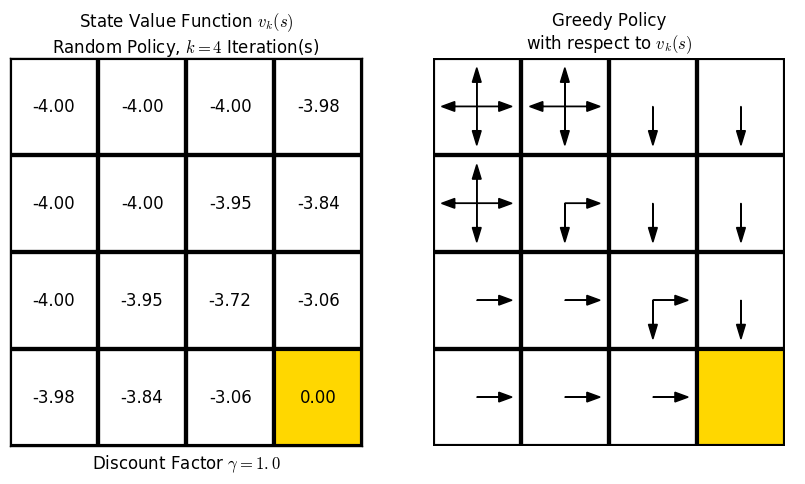

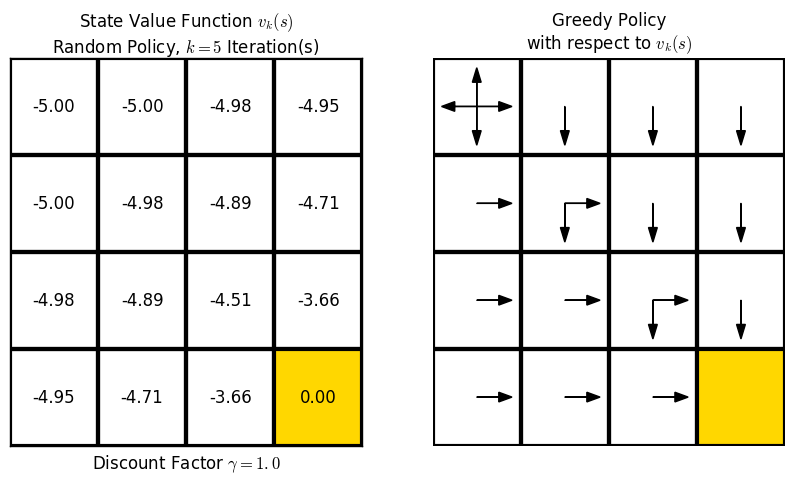

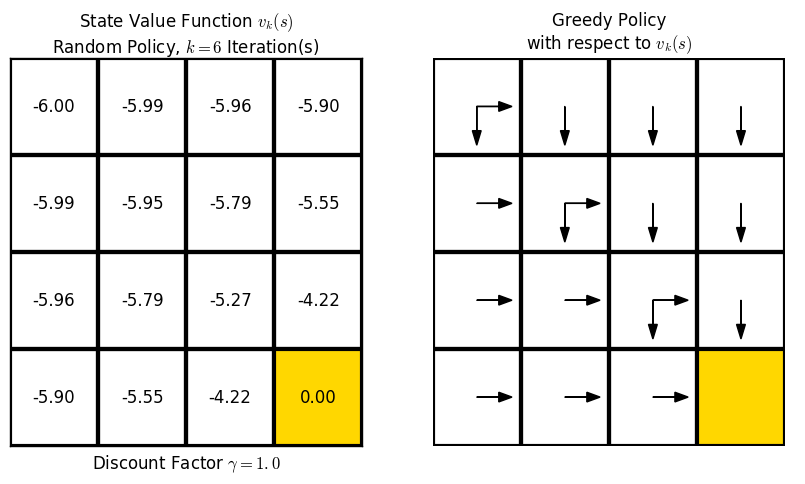

In [6]:
# Third iteration
g1.iterate_value_function()
g1.show_greedy_policy()

# Fourth iteration
g1.iterate_value_function()
g1.show_greedy_policy()

# Fifth iteration
g1.iterate_value_function()
g1.show_greedy_policy()

# Sixth iteration
g1.iterate_value_function()
g1.show_greedy_policy()

Rather than iterate one step at a time, we can iterate until the state value function converges to within a specified tolerance using the `iterate_to_convergence` method. **Run** the cell below to do so.  The converged state value function and corresponding greedy policy for this gridworld will be printed.

Converged to tolerance of 0.0001!


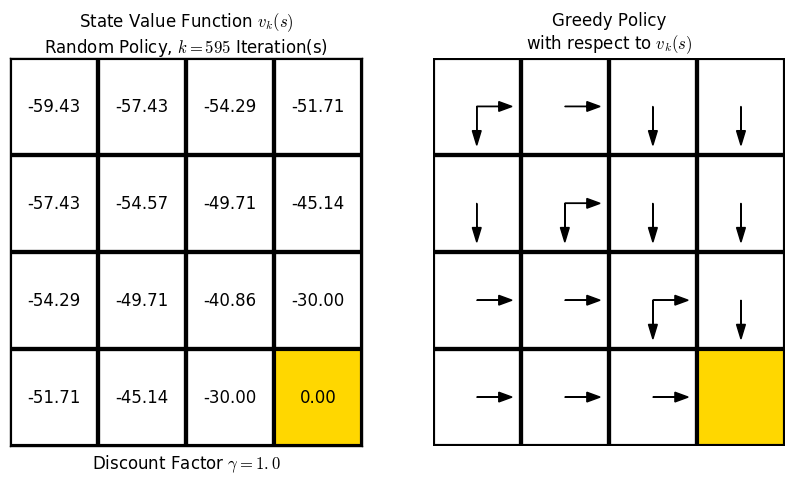

In [7]:
# Iterate to convergence
g1.iterate_to_convergence()
g1.show_greedy_policy()

Once the state value function $v_k(s)$ has converged, we have **evaluated** our policy $\pi$ (in this case, our policy $\pi$ was the random policy). The next step would be to **improve** the policy by replacing $\pi$ with the greedy policy $\pi'$. We would then need to solve the Bellman equation again for the new policy $\pi'$ (policy evaluation), until the state value function $v'_k(s)$ for the new policy converges. This back-and-forth between policy evaluation and policy improvement is called **policy iteration.** Eventually, this process leads to an optimal policy.

As always, feel free to play around with the code and try your own examples -- create a larger gridworld, add multiple goals, change the discount factor. If you'd like to see another example of policy evaluation, **run** the cells below to see how the state value function converges for a gridworld with two terminal states.

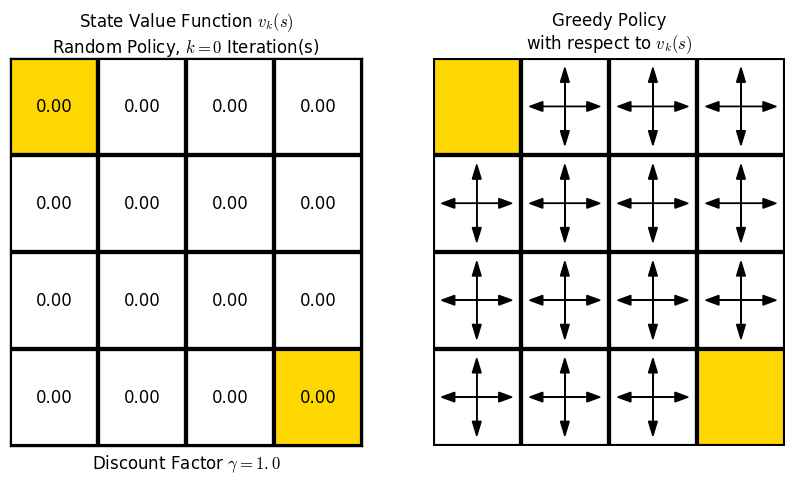

In [8]:
# Initialize gridworld with two terminal states
g2 = Grid(nrows=4, ncols=4, goals = [(0,0),(3,3)], discount = 1.0)
g2.show_greedy_policy()

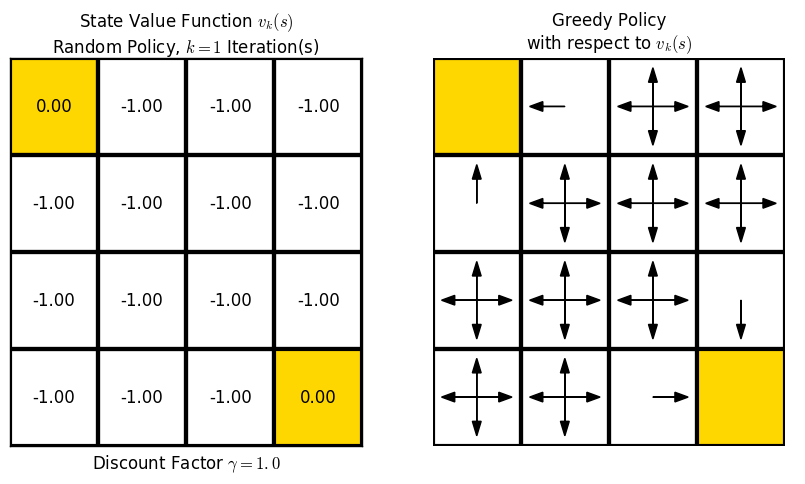

In [9]:
# First iteration
g2.iterate_value_function()
g2.show_greedy_policy()

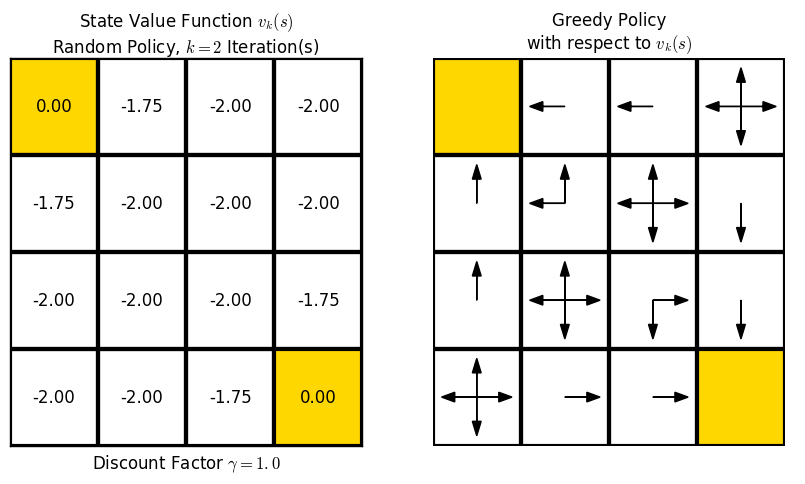

In [10]:
# Second iteration
g2.iterate_value_function()
g2.show_greedy_policy()

Converged to tolerance of 0.0001!


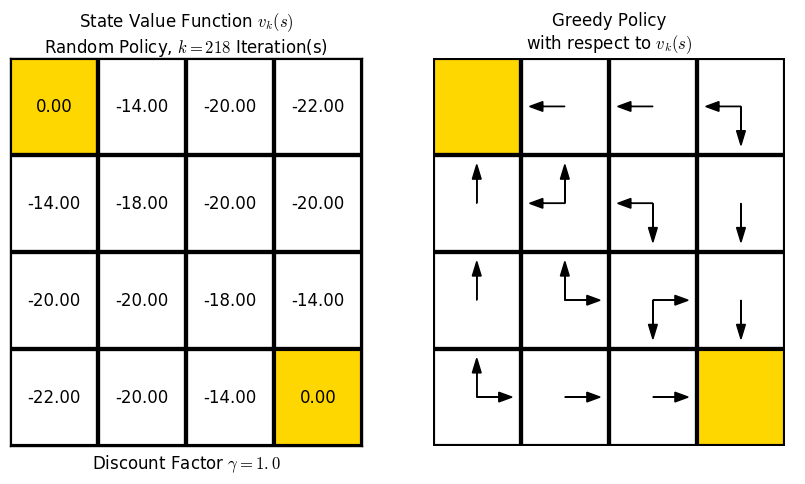

In [11]:
# Iterate to convergence
g2.iterate_to_convergence()
g2.show_greedy_policy()